In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from ggplot import *
import pysam

In [3]:
samples = [
    {'id': 'skm01', 'Ab': 'FLAG', 'control': 'skm27', 'name': 'HepFLAG-WTS1-FLAG'},
    {'id': 'skm02', 'Ab': 'RNAP', 'control': 'skm27', 'name': 'HepFLAG-WTS1-RNAP'},
    {'id': 'skm03', 'Ab': 'S9.6', 'control': 'skm27', 'name': 'HepFLAG-WTS1-S9.6'},

    {'id': 'skm04', 'Ab': 'FLAG', 'control': 'skm28', 'name': 'HepFLAG-S1d56-FLAG'},
    {'id': 'skm05', 'Ab': 'RNAP', 'control': 'skm28', 'name': 'HepFLAG-S1d56-RNAP'},
    {'id': 'skm06', 'Ab': 'S9.6', 'control': 'skm28', 'name': 'HepFLAG-S1d56-S9.6'},
    
    {'id': 'skm07', 'Ab': 'FLAG', 'control': 'skm28', 'name': 'S1d56-HepFLAG-FLAG'},
    {'id': 'skm08', 'Ab': 'RNAP', 'control': 'skm28', 'name': 'S1d56-HepFLAG-RNAP'},
    {'id': 'skm09', 'Ab': 'S9.6', 'control': 'skm28', 'name': 'S1d56-HepFLAG-S9.6'},
    
    {'id': 'skm10', 'Ab': 'FLAG', 'control': 'skm30', 'name': 'S1FLAG-dHep-FLAG'},
    {'id': 'skm11', 'Ab': 'RNAP', 'control': 'skm30', 'name': 'S1FLAG-dHep-RNAP'},
    {'id': 'skm12', 'Ab': 'S9.6', 'control': 'skm30', 'name': 'S1FLAG-dHep-S9.6'},
    
    {'id': 'skm13', 'Ab': 'FLAG', 'control': 'skm25', 'name': 'Hep-FLAG_V-FLAG'},
    {'id': 'skm14', 'Ab': 'RNAP', 'control': 'skm25', 'name': 'Hep-FLAG_V-RNAP'},
    {'id': 'skm15', 'Ab': 'S9.6', 'control': 'skm25', 'name': 'Hep-FLAG_V-S9.6'},
    
    {'id': 'skm16', 'Ab': 'FLAG', 'control': 'skm26', 'name': 'Hep-FLAG_rnh-FLAG'},
    {'id': 'skm17', 'Ab': 'RNAP', 'control': 'skm26', 'name': 'Hep-FLAG_rnh-RNAP'},
    {'id': 'skm18', 'Ab': 'S9.6', 'control': 'skm26', 'name': 'Hep-FLAG_rnh-S9.6'},
    
    {'id': 'skm19', 'Ab': 'FLAG', 'control': 'skm25', 'name': 'S1-FLAG_V-FLAG'},
    {'id': 'skm20', 'Ab': 'RNAP', 'control': 'skm25', 'name': 'S1-FLAG_V-RNAP'},
    {'id': 'skm21', 'Ab': 'S9.6', 'control': 'skm25', 'name': 'S1-FLAG_V-S9.6'},
    
    {'id': 'skm22', 'Ab': 'FLAG', 'control': 'skm26', 'name': 'S1-FLAG_rnh-FLAG'},
    {'id': 'skm23', 'Ab': 'RNAP', 'control': 'skm26', 'name': 'S1-FLAG_rnh-RNAP'},
    {'id': 'skm24', 'Ab': 'S9.6', 'control': 'skm26', 'name': 'S1-FLAG_rnh-S9.6'},
]

In [4]:
def promoter_df(promoters):
    '''
    Parses PromoterSet.txt file from RegulonDB and builds a dataframe
    containing promoter_id, +1 position (TSS), and DNA strand.
    '''
    records = []
    with open(promoters) as fi:
        for line in fi.readlines():
            if line.startswith('#'):
                continue
            else:
                bits = line.strip().split('\t')
                if len(bits) >= 6:
                    records.append({
                            'promoter_id': bits[0],
                            'TSS': int(bits[3]),
                            'strand': bits[2]
                        })
    return pd.DataFrame.from_records(records)
            

def coverage_matrix(bamfile, positions, win=100, reference='gi|556503834|ref|NC_000913.3|'):
       
    def _coverage(rec):
        cov = []
        tss = rec['TSS']
        chrlen = bam.header['SQ'][0]['LN']
        #start = tss - win if tss > win else 0
        #end = tss + win if tss+win < chrlen else chrlen
        if (tss > win) and (tss+win < chrlen):
            start = tss - win
            end = tss + win
            for p in bam.pileup(reference, start, end, max_depth=1e9):
                cov.append({
                        'offset': p.pos - tss,
                        'coverage': p.n,
                        'strand': rec['strand']
                    })
        return cov
    
    def update_agg(agg, rec):
        if rec['offset'] in agg:
            agg[rec['offset']] += rec['coverage']
        else:
            agg[rec['offset']] = rec['coverage']
            
    def df_agg(agg, strand):
        df = pd.DataFrame.from_dict(agg, orient='index')
        df['offset'] = df.index
        df['coverage'] = df[0]
        df['strand'] = strand
        return df    
    
    offsets = []
    bam = pysam.AlignmentFile(bamfile, 'rb')
    
    for i,rec in positions.iterrows():
        offsets.append(_coverage(rec))
        
    agg_plus = {}
    agg_minus = {}
    for item in offsets[1:]:
        for rec in item:
            if -win < rec['offset'] < win:
                if rec['strand'] == 'forward':
                    update_agg(agg_plus, rec)
                else:
                    update_agg(agg_minus, rec)
                    
                    

    _plus = df_agg(agg_plus, 'forward')
    _minus = df_agg(agg_minus, 'reverse')
    return pd.concat([_plus, _minus])

In [5]:
pdf = promoter_df('../ref/ecoli/PromoterSet.corr.txt')
pdf

,TSS,promoter_id,strand
0,38,ECK125153230,forward
1,2581,ECK125153239,forward
2,55146,ECK125153329,reverse
3,892926,ECK125154229,forward
4,900345,ECK125154230,reverse
5,900605,ECK125154231,reverse
6,902050,ECK125154233,reverse
7,902184,ECK125154234,reverse
8,902897,ECK125154235,reverse
9,903004,ECK125154236,reverse


In [6]:
bam_tpl = "../results/{id}/{id}_sorted.bam"

for sample in samples:
    sample_bam = bam_tpl.format(id=sample['id'])
    print("\t...processing {} ...".format(sample['id']))
    sample['cm'] = coverage_matrix(sample_bam, pdf, win=500)

	...processing skm01 ...
	...processing skm02 ...
	...processing skm03 ...
	...processing skm04 ...
	...processing skm05 ...
	...processing skm06 ...
	...processing skm07 ...
	...processing skm08 ...
	...processing skm09 ...
	...processing skm10 ...
	...processing skm11 ...
	...processing skm12 ...
	...processing skm13 ...
	...processing skm14 ...
	...processing skm15 ...
	...processing skm16 ...
	...processing skm17 ...
	...processing skm18 ...
	...processing skm19 ...
	...processing skm20 ...
	...processing skm21 ...
	...processing skm22 ...
	...processing skm23 ...
	...processing skm24 ...


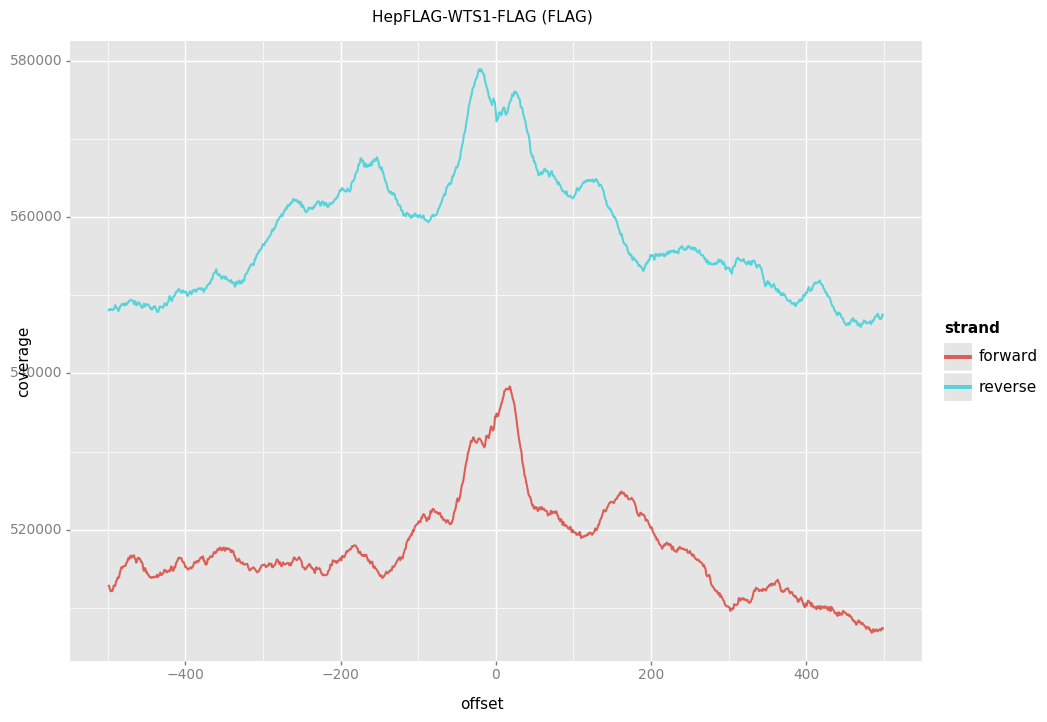

<ggplot: (8762166671381)>


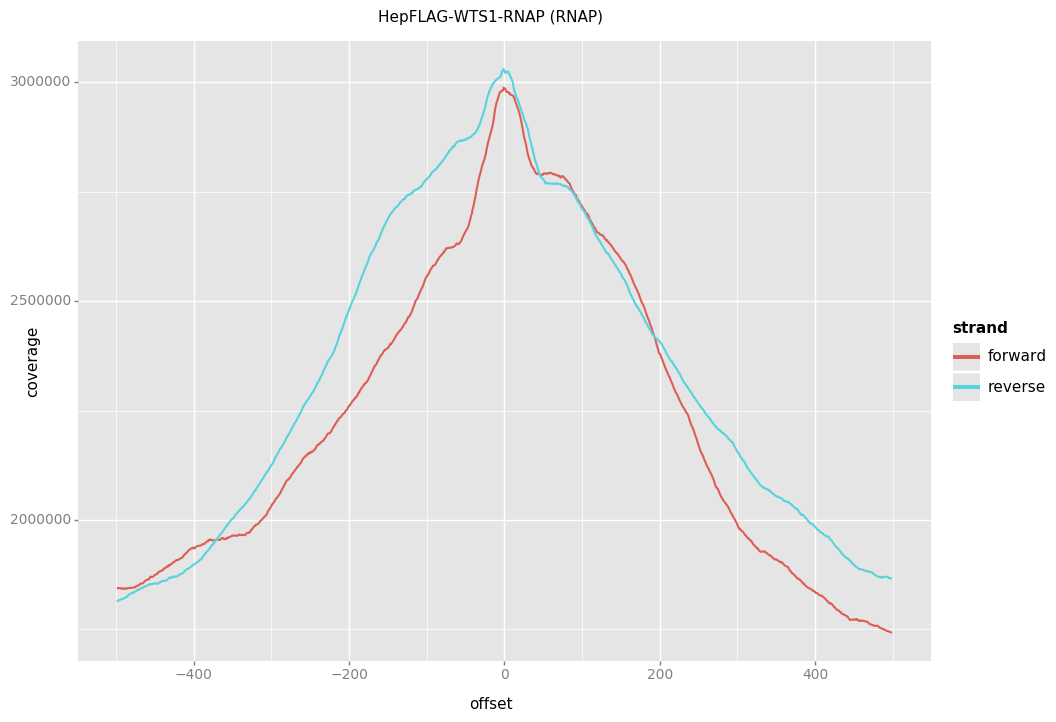

<ggplot: (8762166217981)>


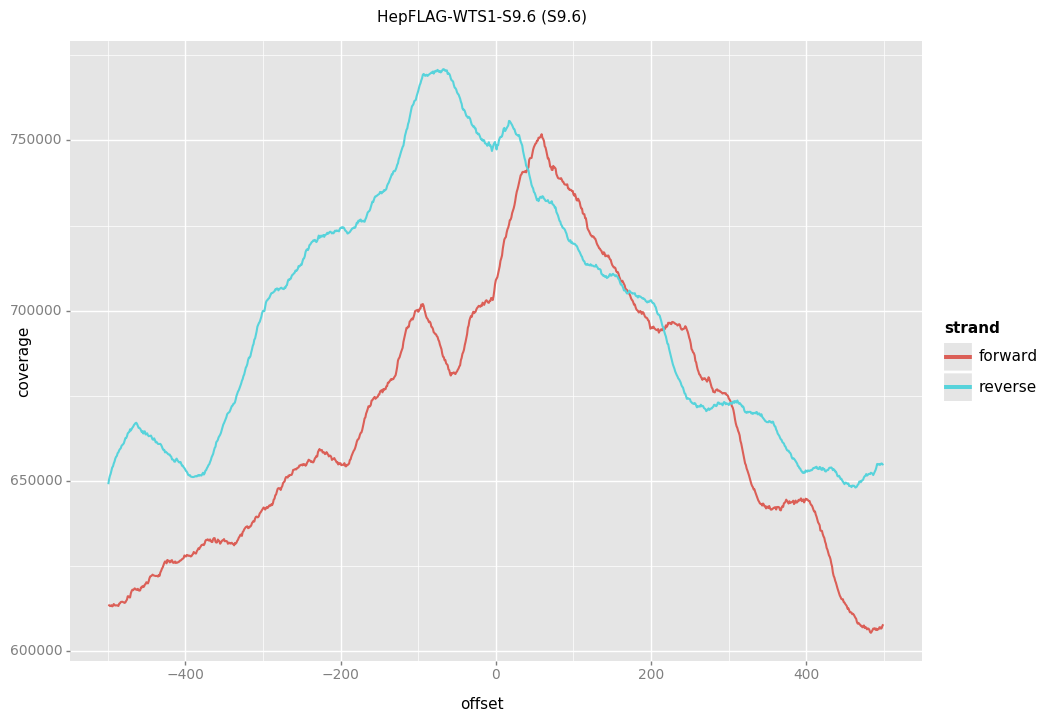

<ggplot: (8762166617557)>


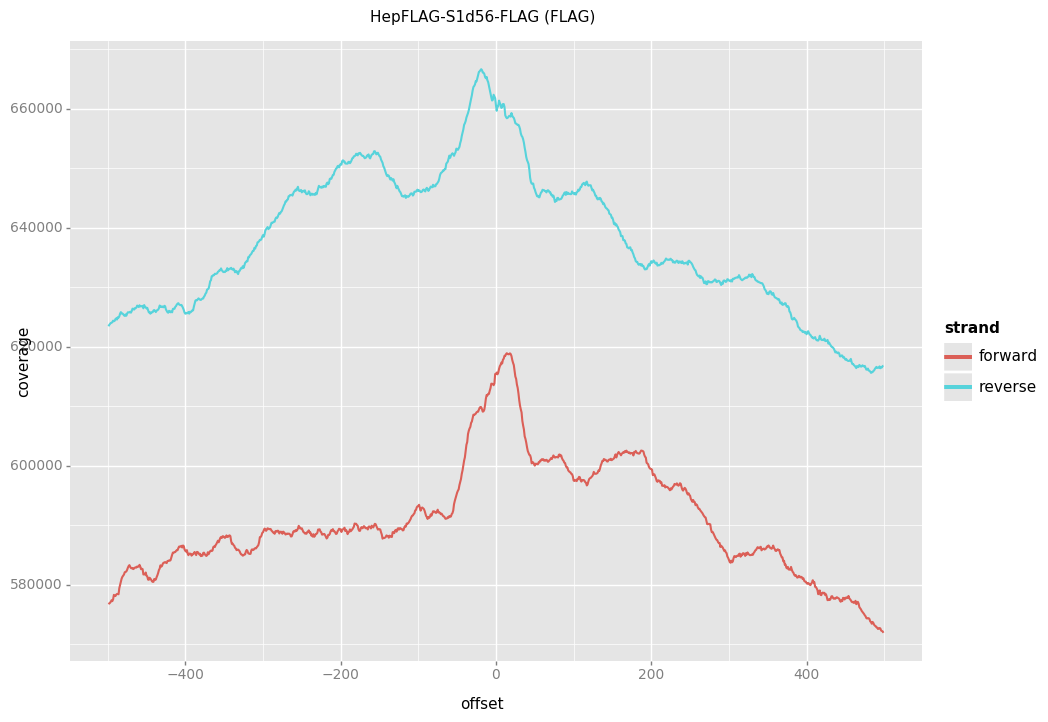

<ggplot: (8762166126477)>


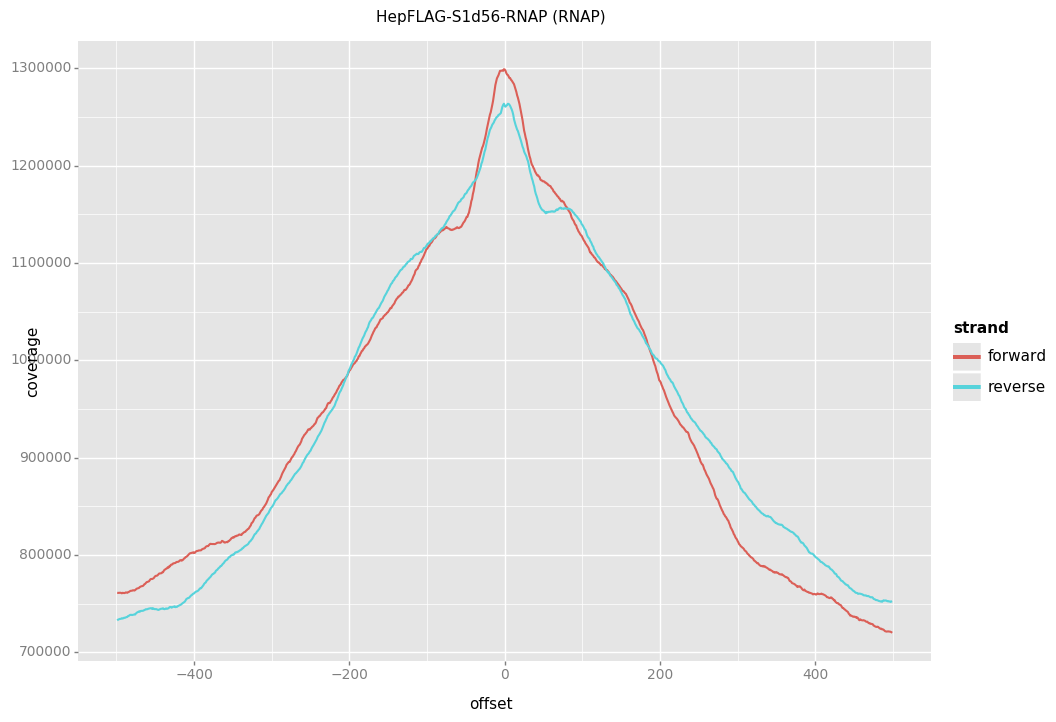

<ggplot: (8762166461525)>


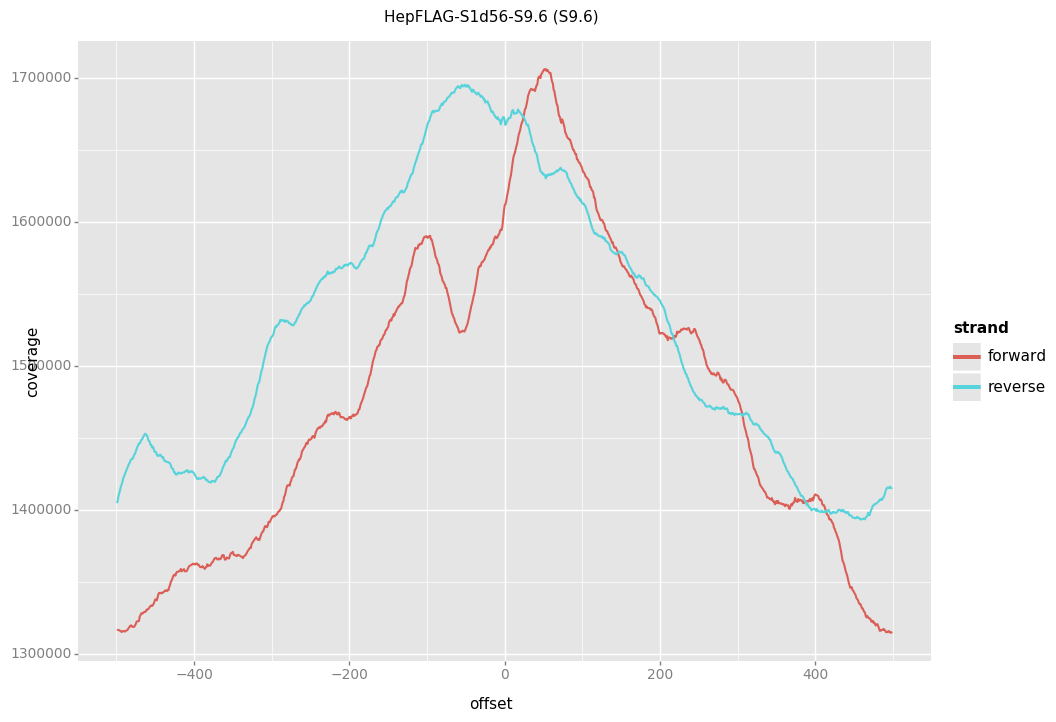

<ggplot: (8762166217773)>


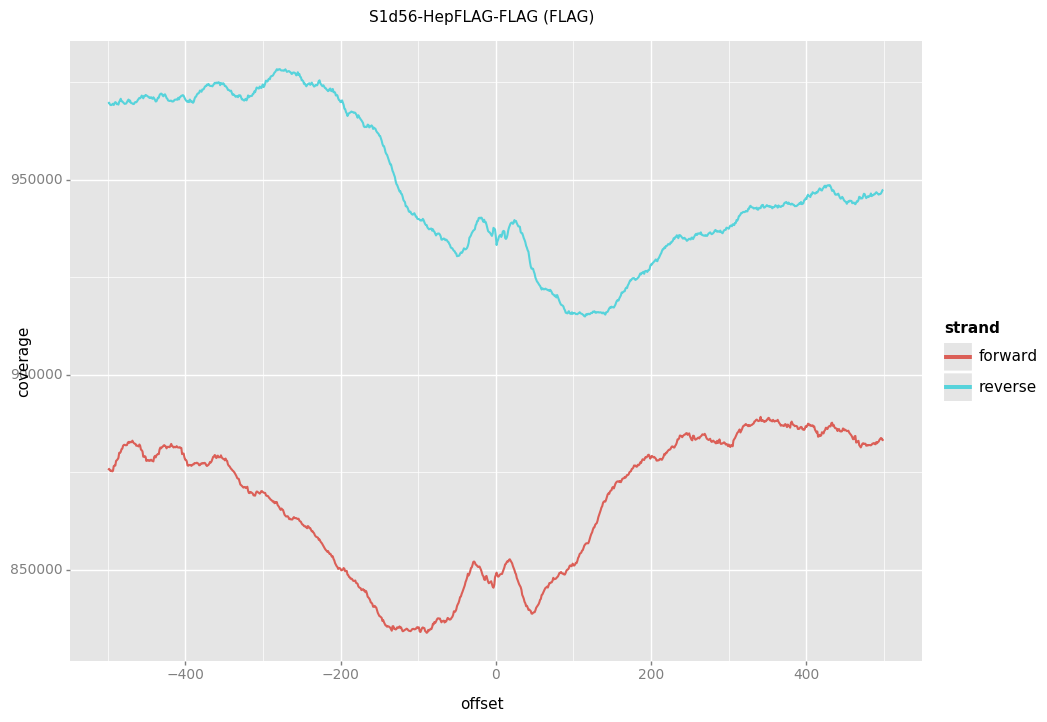

<ggplot: (8762166173837)>


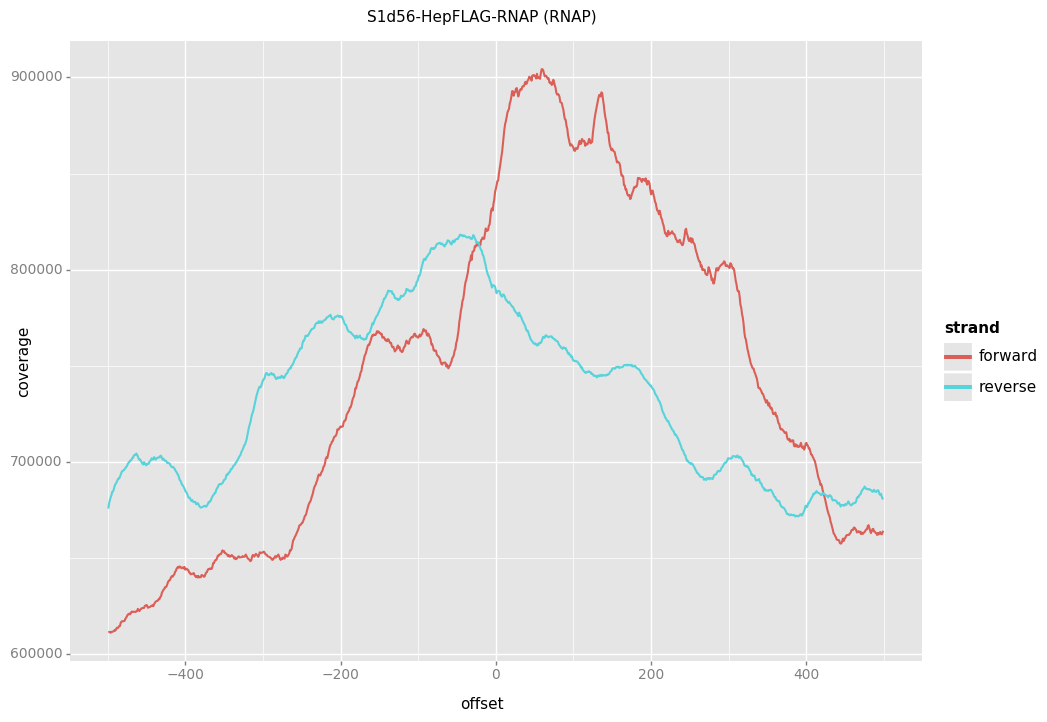

<ggplot: (8762332341005)>


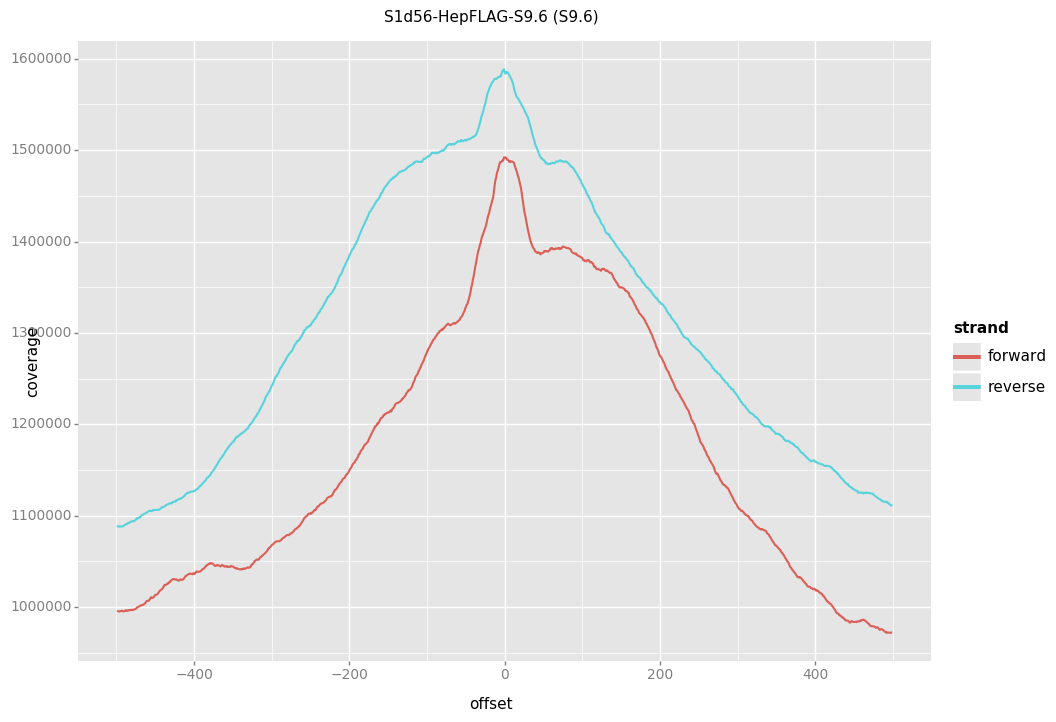

<ggplot: (8762332294761)>


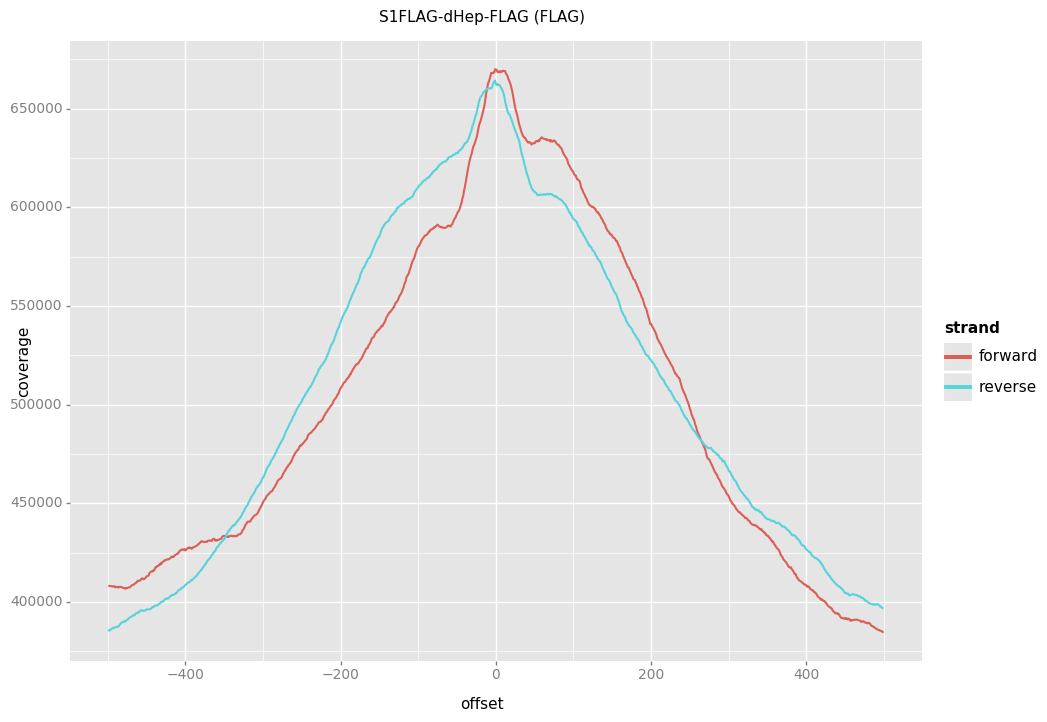

<ggplot: (8762332431073)>


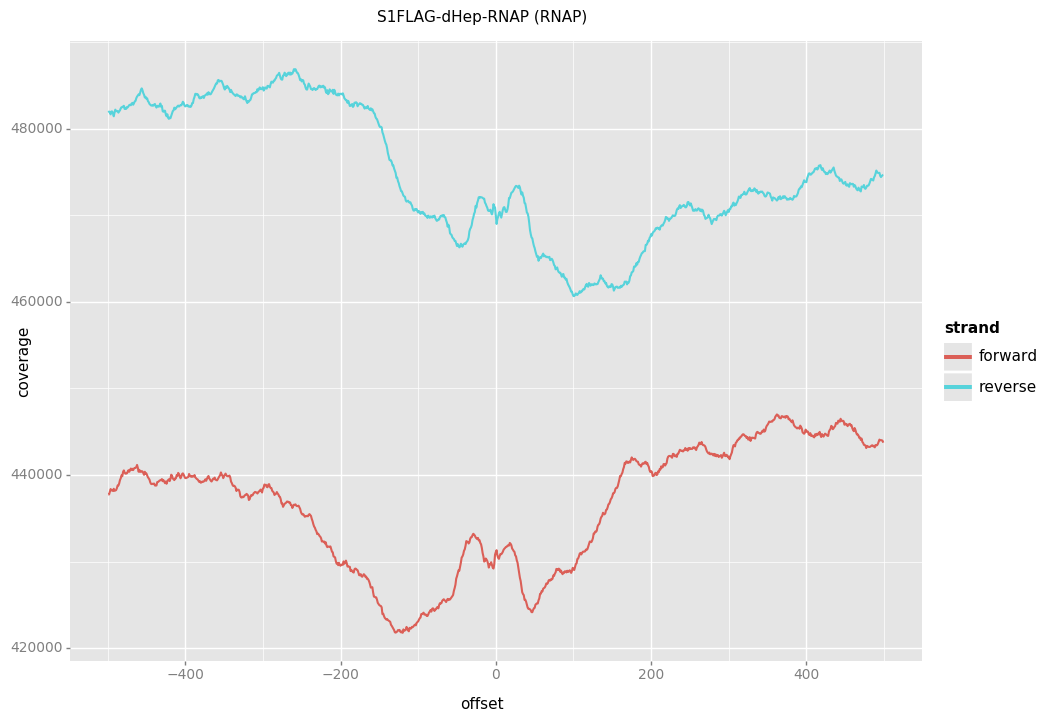

<ggplot: (8762166144465)>


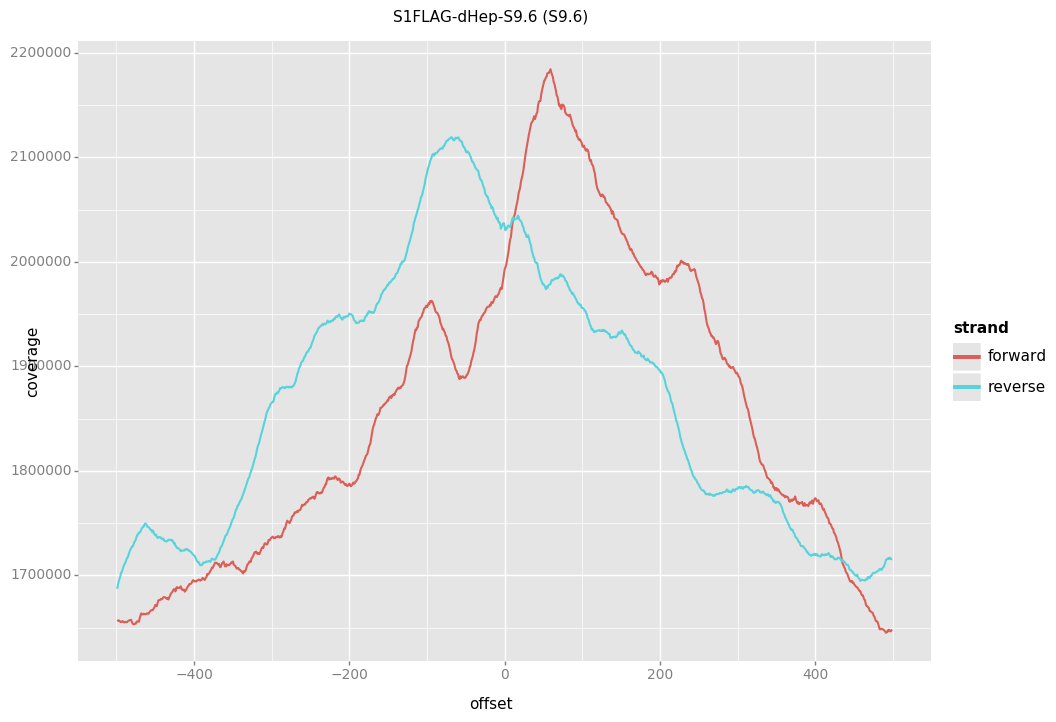

<ggplot: (8762166451937)>


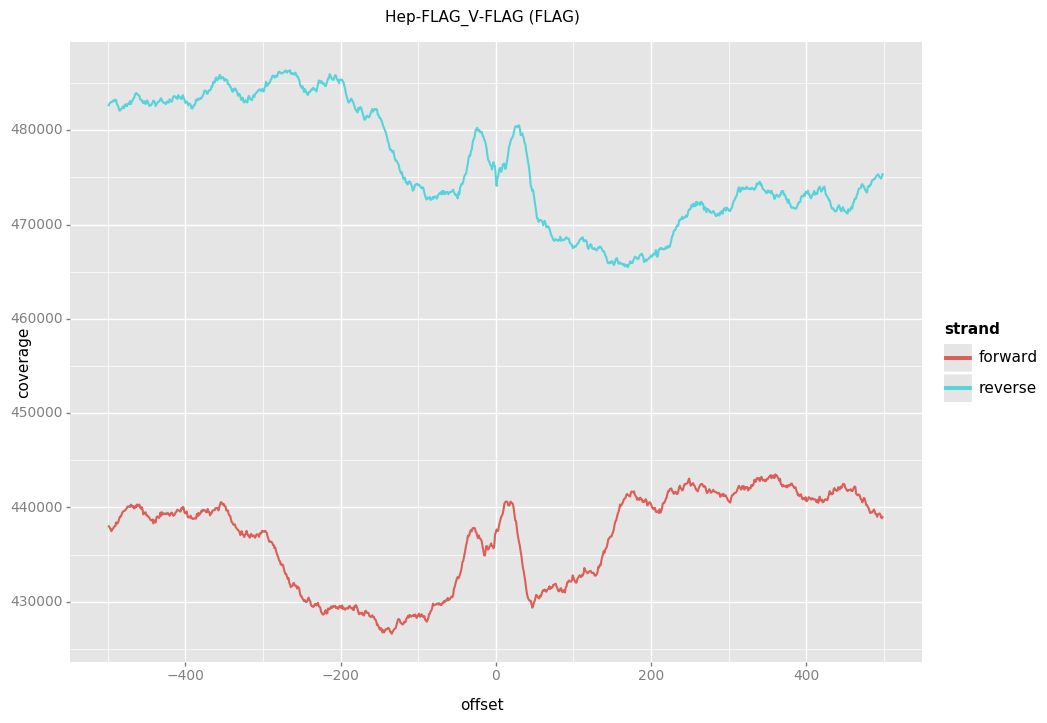

<ggplot: (8762166656201)>


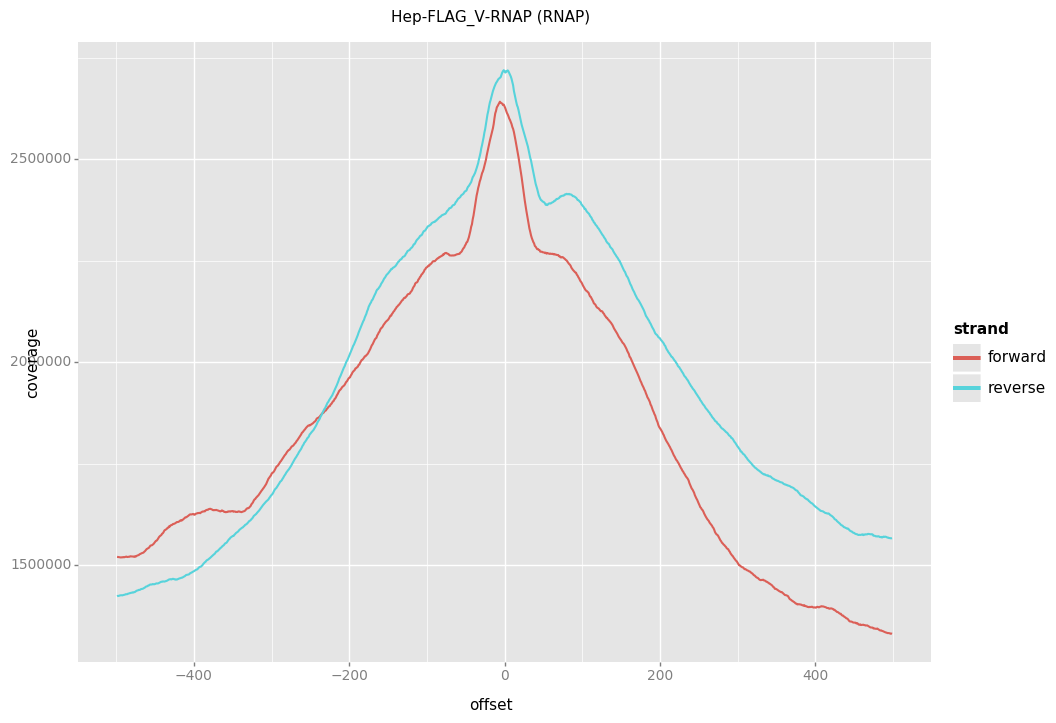

<ggplot: (8762166785261)>


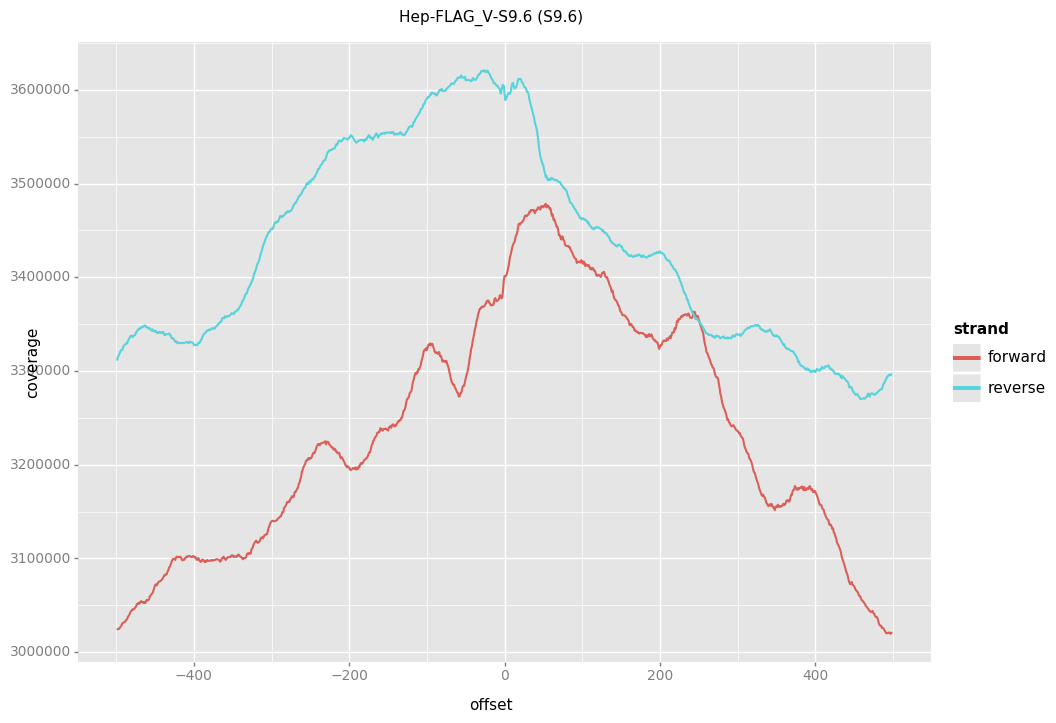

<ggplot: (8762167887433)>


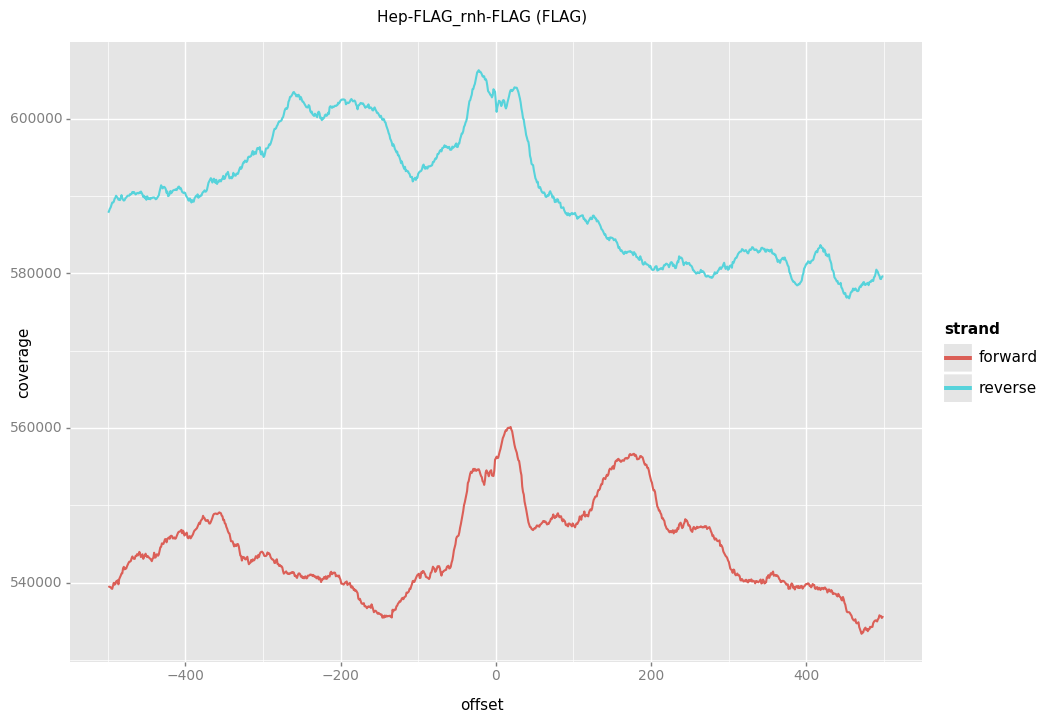

<ggplot: (8762166903637)>


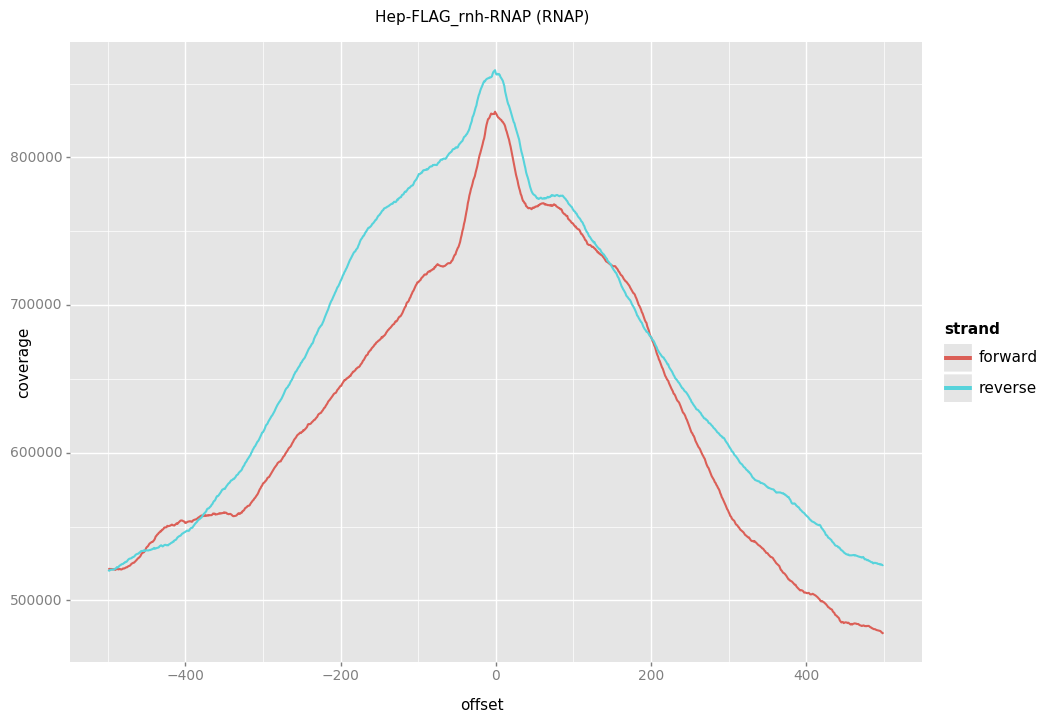

<ggplot: (8762332425265)>


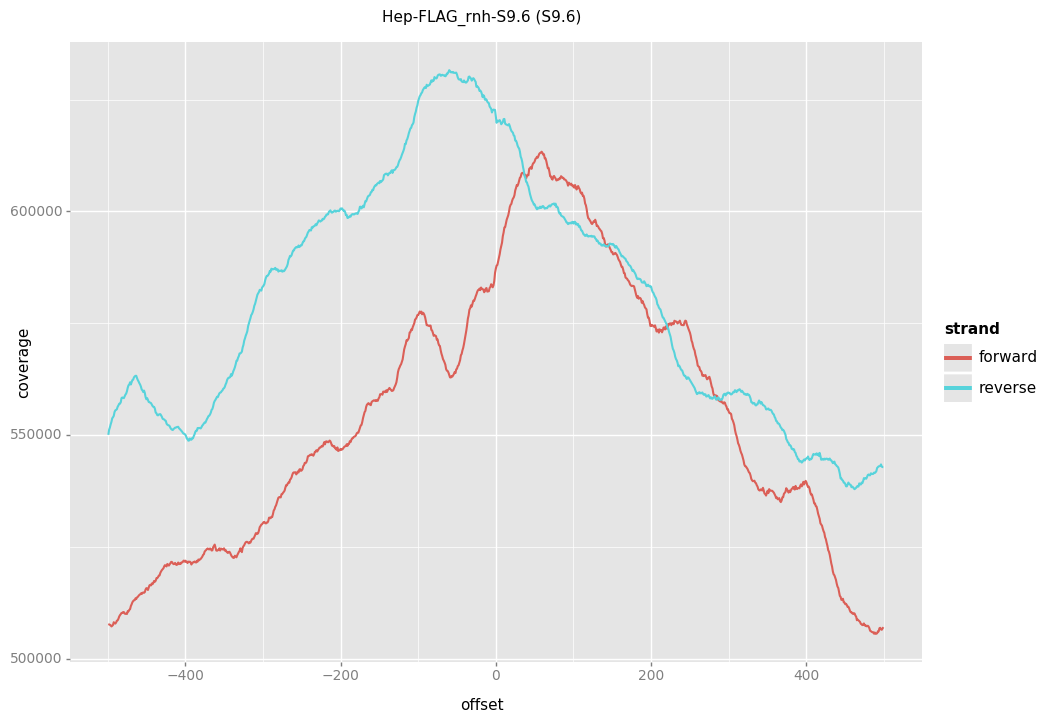

<ggplot: (8762166787125)>


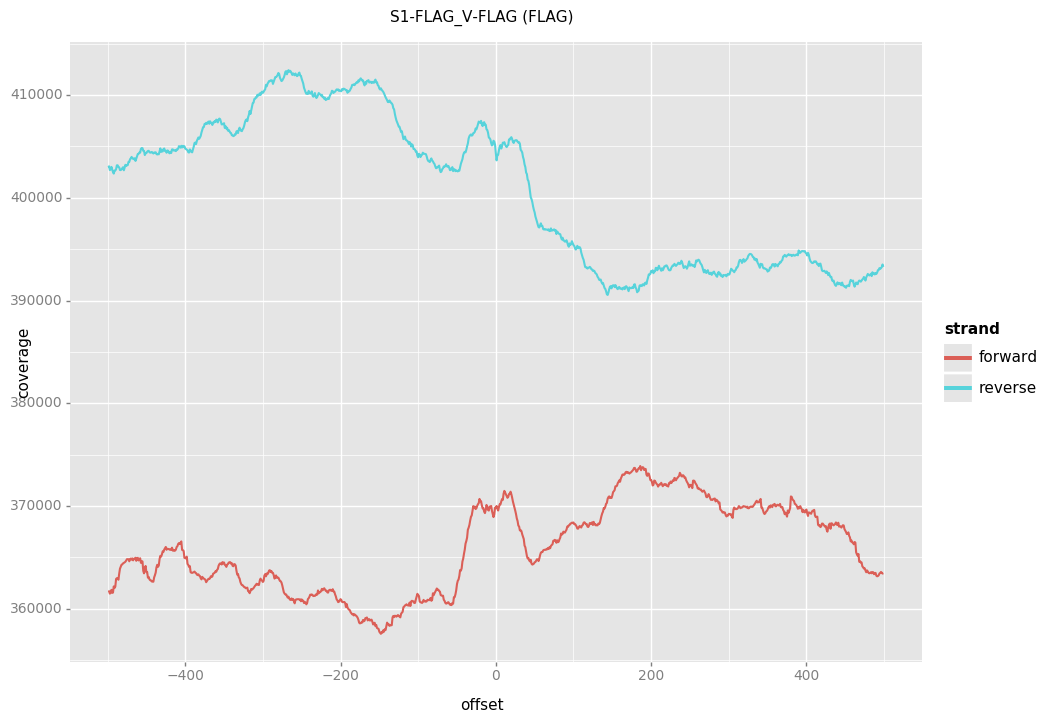

<ggplot: (8762166321049)>


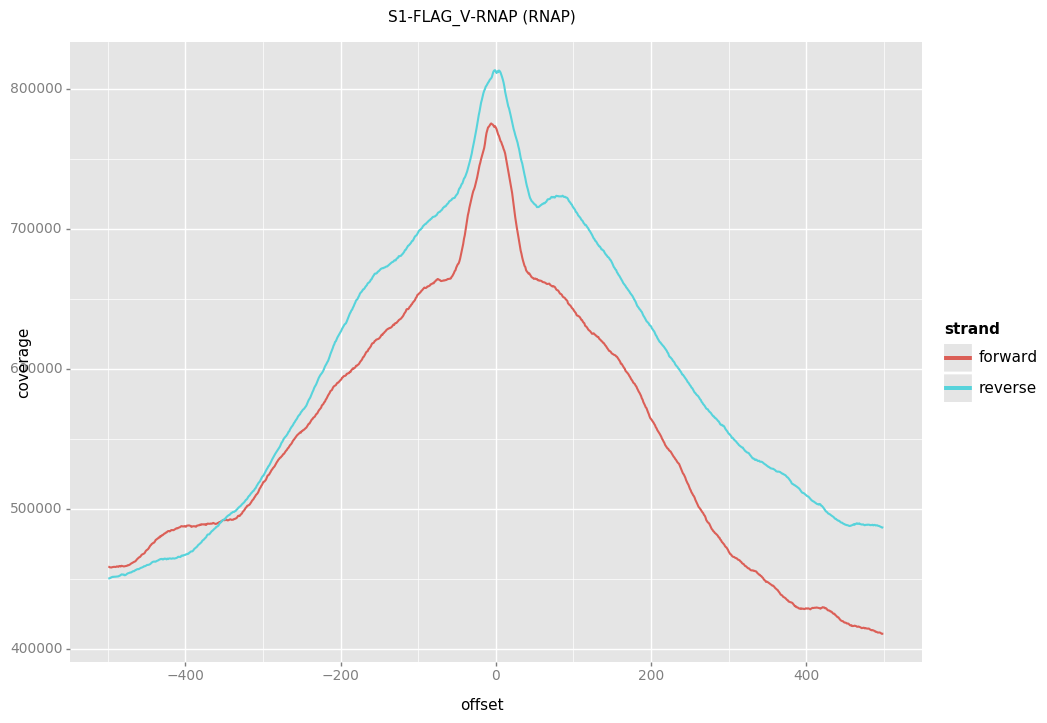

<ggplot: (8762168956141)>


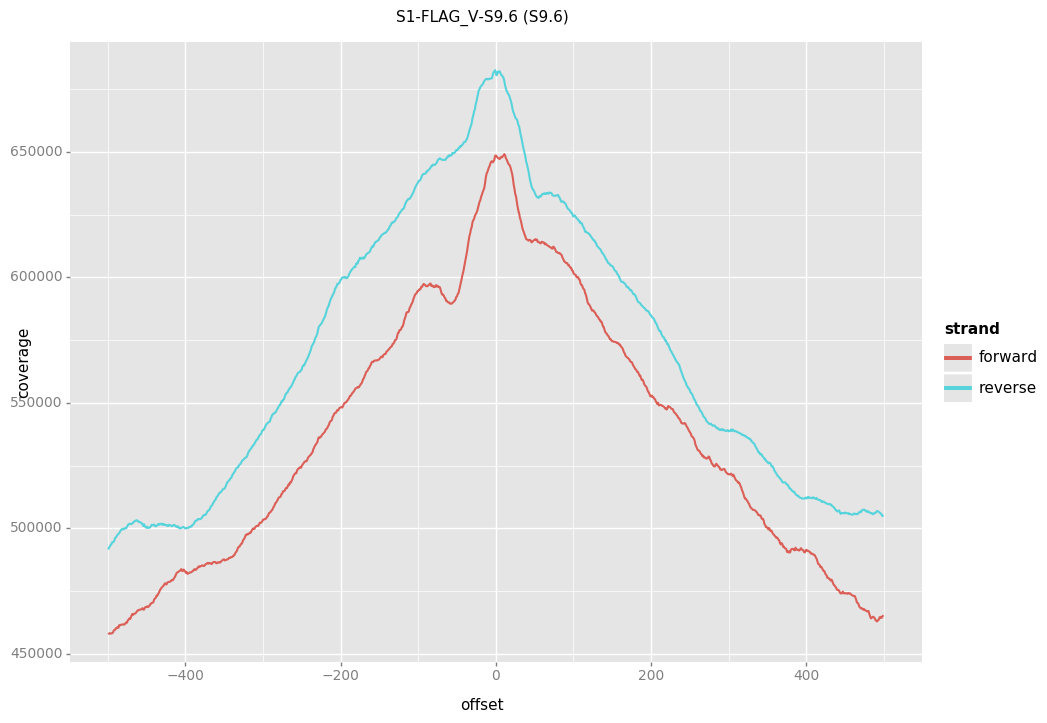

<ggplot: (8762166342141)>


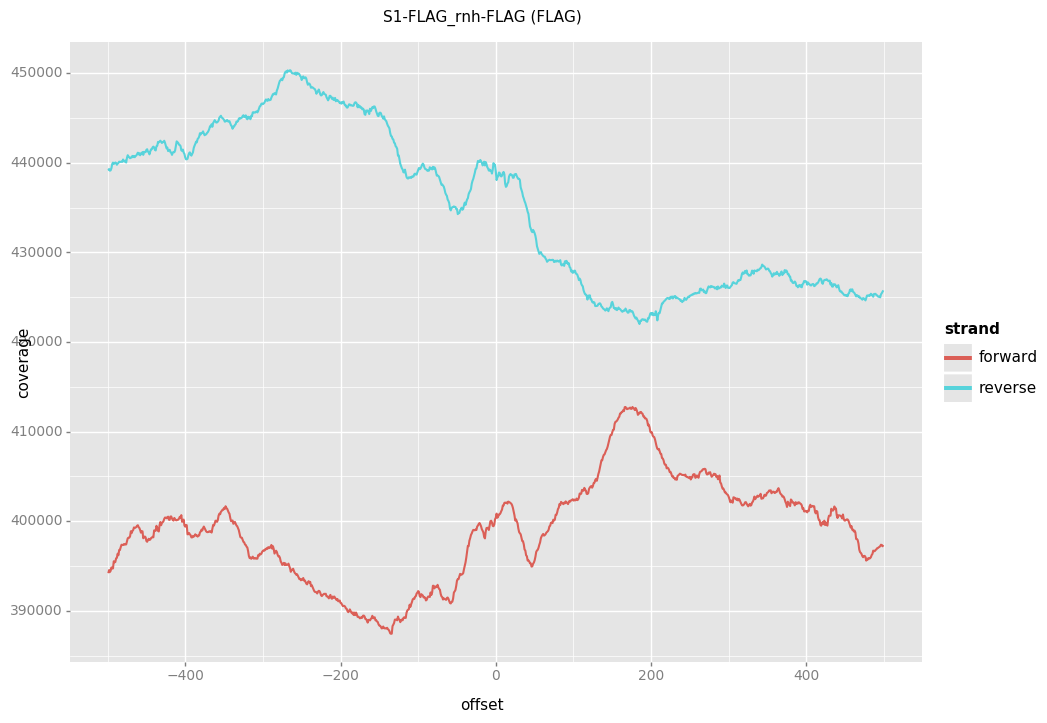

<ggplot: (8762332298593)>


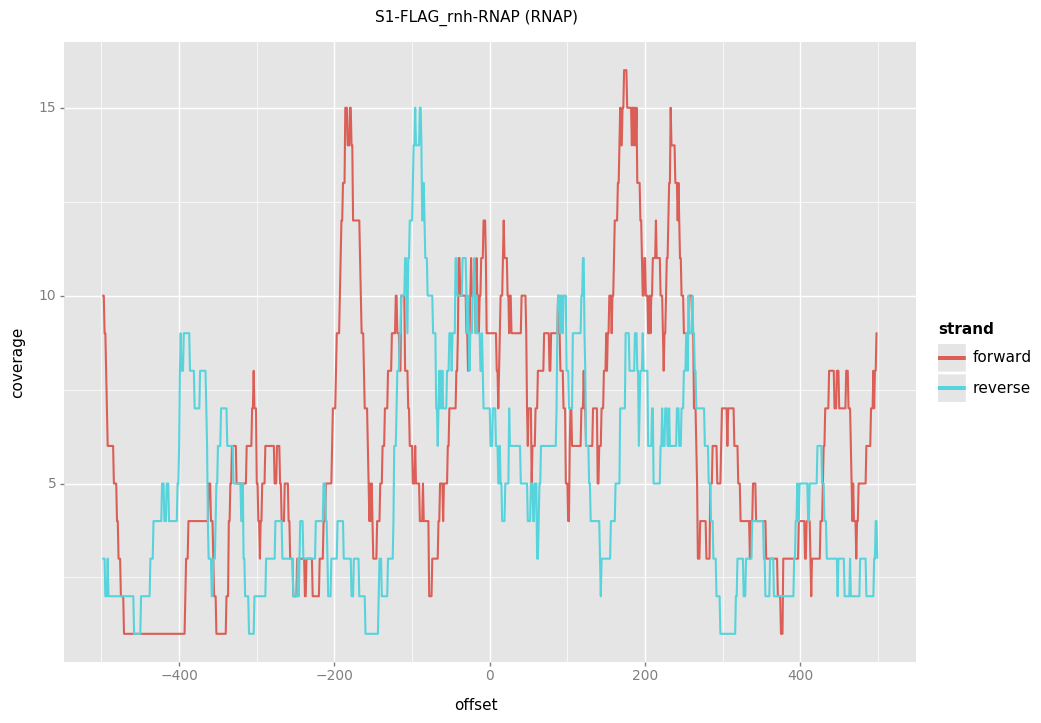

<ggplot: (8762166713317)>


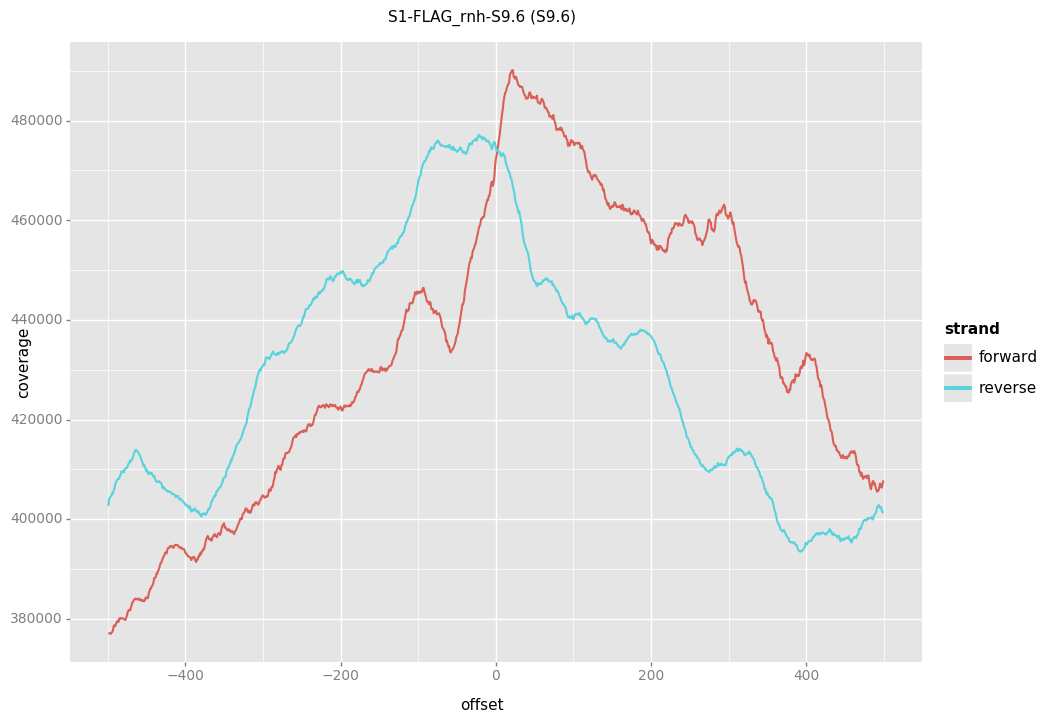

<ggplot: (8762166142857)>


In [7]:
for sample in samples:
    p = ggplot(sample['cm'], aes(x='offset', y='coverage', color='strand')) \
        + geom_line() \
        + ggtitle('{0} ({1})'.format(sample['name'], sample['Ab']))
    print(p)

In [8]:
for sample in samples:
    sample['cm'].to_csv('../results/{}/{}.cm.csv'.format(sample['id'], sample['id']))

In [9]:
ls -lah ../results/skm01

total 1.4G
drwxr-xr-x  2 ilya ilya 4.0K Oct 31 08:19 ./
drwxr-xr-x 36 ilya lab  4.0K Oct 24 23:00 ../
-rw-r--r--  1 ilya ilya  44K Oct 28 10:44 HepFLAG-WTS1-FLAG_peaks.narrowPeak
-rw-r--r--  1 ilya ilya  49K Oct 28 10:44 HepFLAG-WTS1-FLAG_peaks.xls
-rw-r--r--  1 ilya ilya  33K Oct 28 10:44 HepFLAG-WTS1-FLAG_summits.bed
-rw-r--r--  1 ilya ilya 767M Oct 24 19:26 skm01.bam
-rw-r--r--  1 ilya ilya  60K Oct 31 08:19 skm01.cm.csv
-rw-r--r--  1 ilya ilya 626M Oct 25 08:32 skm01_sorted.bam
-rw-r--r--  1 ilya ilya  15K Oct 25 09:02 skm01_sorted.bam.bai
